In [1]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import math
import os
import re
import requests
import pathlib
import tspex

import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests as r
import seaborn as sns
import xml.etree.ElementTree as ET

from Bio import SeqIO
from io import StringIO
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from scipy.integrate import simps

In [51]:
raw_data = pd.read_csv(raw_data_path, sep = ";")

In [54]:
raw_data

,SampleID,Sample_Type,Index,OlinkID,UniProt,Assay,MissingFreq,Panel,Panel_Lot_Nr,PlateID,...,LOD,NPX,Normalization,Assay_Warning,IntraCV,InterCV,Processing_StartDate,Processing_EndDate,AnalyzerID,ExploreVersion
0,SM-N8JPG,SAMPLE,1,OID20001,INC1,Incubation control 1,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,0.1038,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
1,SM-N8JPM,SAMPLE,2,OID20001,INC1,Incubation control 1,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,0.1803,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
2,SM-N8JPH,SAMPLE,3,OID20001,INC1,Incubation control 1,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,0.0820,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
3,SM-N8JPN,SAMPLE,4,OID20001,INC1,Incubation control 1,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,0.0408,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
4,SM-N8JPI,SAMPLE,5,OID20001,INC1,Incubation control 1,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,-0.0992,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288763,SM-N8JS4,SAMPLE,92,OID31526,Q96R05,RBP7,0.8977,Oncology_II,E61005,LCSET28343_layout,...,1.4381,-0.8236,Intensity,PASS,1.7756,1.7756,20231003,20231003,A00442,3.5.3
288764,SM-N8JRY,SAMPLE,93,OID31526,Q96R05,RBP7,0.8977,Oncology_II,E61005,LCSET28343_layout,...,1.4381,-0.9589,Intensity,PASS,1.7756,1.7756,20231003,20231003,A00442,3.5.3
288765,SM-N8JS5,SAMPLE,94,OID31526,Q96R05,RBP7,0.8977,Oncology_II,E61005,LCSET28343_layout,...,1.4381,6.3326,Intensity,PASS,1.7756,1.7756,20231003,20231003,A00442,3.5.3
288766,SM-N8JRZ,SAMPLE,95,OID31526,Q96R05,RBP7,0.8977,Oncology_II,E61005,LCSET28343_layout,...,1.4381,0.5168,Intensity,PASS,1.7756,1.7756,20231003,20231003,A00442,3.5.3


In [81]:
raw_data[raw_data["Sample_Type"] == "CONTROL"]

,SampleID,Sample_Type,Index,OlinkID,UniProt,Assay,MissingFreq,Panel,Panel_Lot_Nr,PlateID,...,LOD,NPX,Normalization,Assay_Warning,IntraCV,InterCV,Processing_StartDate,Processing_EndDate,AnalyzerID,ExploreVersion
11,Olink_Sample_Control77,CONTROL,12,OID20001,INC1,Incubation control 1,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,-0.1039,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
23,Olink_Sample_Control76,CONTROL,24,OID20001,INC1,Incubation control 1,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,-0.1968,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
107,Olink_Sample_Control77,CONTROL,12,OID20017,AMP1,Amplification control 1,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,0.0621,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
119,Olink_Sample_Control76,CONTROL,24,OID20017,AMP1,Amplification control 1,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,0.0545,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
203,Olink_Sample_Control77,CONTROL,12,OID20049,P16860,NPPB,0.7841,Cardiometabolic,B23407,LCSET28343_layout,...,0.8398,5.5893,Intensity,PASS,14.3453,14.3453,20231003,20231003,A00438,3.5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288503,Olink_Sample_Control76,CONTROL,24,OID31524,Q8IWZ8,SUGP1,0.9205,Oncology_II,E61005,LCSET28343_layout,...,0.3876,0.1872,Intensity,PASS,NaN,NaN,20231003,20231003,A00442,3.5.3
288587,Olink_Sample_Control77,CONTROL,12,OID31525,O15182,CETN3,0.3068,Oncology_II,E61005,LCSET28343_layout,...,-0.0730,0.4441,Intensity,PASS,4.6076,4.6076,20231003,20231003,A00442,3.5.3
288599,Olink_Sample_Control76,CONTROL,24,OID31525,O15182,CETN3,0.3068,Oncology_II,E61005,LCSET28343_layout,...,-0.0730,0.3502,Intensity,PASS,4.6076,4.6076,20231003,20231003,A00442,3.5.3
288683,Olink_Sample_Control77,CONTROL,12,OID31526,Q96R05,RBP7,0.8977,Oncology_II,E61005,LCSET28343_layout,...,1.4381,6.6877,Intensity,PASS,1.7756,1.7756,20231003,20231003,A00442,3.5.3


In [82]:
raw_data["SampleID"].unique()

array(['SM-N8JPG', 'SM-N8JPM', 'SM-N8JPH', 'SM-N8JPN', 'SM-N8JPI',
       'SM-N8JPO', 'SM-N8JPJ', 'SM-N8JPP', 'SM-N8JPK', 'SM-N8JPQ',
       'SM-N8JPL', 'Olink_Sample_Control77', 'SM-N8JPS', 'SM-N8JPY',
       'SM-N8JPT', 'SM-N8JPZ', 'SM-N8JPU', 'SM-N8JQ1', 'SM-N8JPV',
       'SM-N8JQ2', 'SM-N8JPW', 'SM-N8JQ3', 'SM-N8JPX',
       'Olink_Sample_Control76', 'SM-N8JQ5', 'SM-N8JQB', 'SM-N8JQ6',
       'SM-N8JQC', 'SM-N8JQ7', 'SM-N8JQD', 'SM-N8JQ8', 'SM-N8JQE',
       'SM-N8JQ9', 'SM-N8JQF', 'SM-N8JQA', 'Olink_Negative_Control65',
       'SM-N8JQH', 'SM-N8JQN', 'SM-N8JQI', 'SM-N8JQO', 'SM-N8JQJ',
       'SM-N8JQP', 'SM-N8JQK', 'SM-N8JQQ', 'SM-N8JQL', 'SM-N8JQR',
       'SM-N8JQM', 'Olink_Negative_Control66', 'SM-N8JQT', 'SM-N8JQZ',
       'SM-N8JQU', 'SM-N8JR1', 'SM-N8JQV', 'SM-N8JR2', 'SM-N8JQW',
       'SM-N8JR3', 'SM-N8JQX', 'SM-N8JR4', 'SM-N8JQY',
       'Olink_Negative_Control67', 'SM-N8JR6', 'SM-N8JRC', 'SM-N8JR7',
       'SM-N8JRD', 'SM-N8JR8', 'SM-N8JRE', 'SM-N8JR9', 'SM-N8JRF',
   

In [57]:
sample = raw_data[raw_data["SampleID"] == "SM-N8JPG"]

In [80]:
sample[sample["Assay"].str.contains("control")]

,SampleID,Sample_Type,Index,OlinkID,UniProt,Assay,MissingFreq,Panel,Panel_Lot_Nr,PlateID,...,LOD,NPX,Normalization,Assay_Warning,IntraCV,InterCV,Processing_StartDate,Processing_EndDate,AnalyzerID,ExploreVersion
0,SM-N8JPG,SAMPLE,1,OID20001,INC1,Incubation control 1,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,0.1038,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
96,SM-N8JPG,SAMPLE,1,OID20017,AMP1,Amplification control 1,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,-0.0021,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
7008,SM-N8JPG,SAMPLE,1,OID20005,INC2,Incubation control 2,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,-0.1619,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
7104,SM-N8JPG,SAMPLE,1,OID20021,AMP2,Amplification control 2,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,-0.1874,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
18144,SM-N8JPG,SAMPLE,1,OID20009,INC3,Incubation control 3,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,0.1387,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261792,SM-N8JPG,SAMPLE,1,OID30024,AMP2,Amplification control 2,NaN,Oncology_II,E61005,LCSET28343_layout,...,NaN,-0.1961,Intensity,PASS,NaN,NaN,20231003,20231003,A00442,3.5.3
270336,SM-N8JPG,SAMPLE,1,OID30012,INC3,Incubation control 3,NaN,Oncology_II,E61005,LCSET28343_layout,...,NaN,0.0813,Intensity,PASS,NaN,NaN,20231003,20231003,A00442,3.5.3
270432,SM-N8JPG,SAMPLE,1,OID30028,AMP3,Amplification control 3,NaN,Oncology_II,E61005,LCSET28343_layout,...,NaN,0.0290,Intensity,PASS,NaN,NaN,20231003,20231003,A00442,3.5.3
279456,SM-N8JPG,SAMPLE,1,OID30016,INC4,Incubation control 4,NaN,Oncology_II,E61005,LCSET28343_layout,...,NaN,-0.0383,Intensity,PASS,NaN,NaN,20231003,20231003,A00442,3.5.3


In [78]:
sample

,SampleID,Sample_Type,Index,OlinkID,UniProt,Assay,MissingFreq,Panel,Panel_Lot_Nr,PlateID,...,LOD,NPX,Normalization,Assay_Warning,IntraCV,InterCV,Processing_StartDate,Processing_EndDate,AnalyzerID,ExploreVersion
0,SM-N8JPG,SAMPLE,1,OID20001,INC1,Incubation control 1,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,0.1038,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
96,SM-N8JPG,SAMPLE,1,OID20017,AMP1,Amplification control 1,NaN,Cardiometabolic,B23407,LCSET28343_layout,...,NaN,-0.0021,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
192,SM-N8JPG,SAMPLE,1,OID20049,P16860,NPPB,0.7841,Cardiometabolic,B23407,LCSET28343_layout,...,0.8398,1.3972,Intensity,PASS,14.3453,14.3453,20231003,20231003,A00438,3.5.3
288,SM-N8JPG,SAMPLE,1,OID20050,P19429,TNNI3,1.0000,Cardiometabolic,B23407,LCSET28343_layout,...,7.0930,5.3488,Intensity,PASS,NaN,NaN,20231003,20231003,A00438,3.5.3
384,SM-N8JPG,SAMPLE,1,OID20051,P61978,HNRNPK,0.1477,Cardiometabolic,B23407,LCSET28343_layout,...,-0.3775,-0.2556,Intensity,PASS,7.1029,7.1029,20231003,20231003,A00438,3.5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288288,SM-N8JPG,SAMPLE,1,OID31522,Q9NPJ3,ACOT13,0.9659,Oncology_II,E61005,LCSET28343_layout,...,1.0571,-1.0059,Intensity,PASS,5.6655,5.6655,20231003,20231003,A00442,3.5.3
288384,SM-N8JPG,SAMPLE,1,OID31523,P62330,ARF6,0.5341,Oncology_II,E61005,LCSET28343_layout,...,0.1365,-1.9646,Intensity,PASS,0.0085,0.0085,20231003,20231003,A00442,3.5.3
288480,SM-N8JPG,SAMPLE,1,OID31524,Q8IWZ8,SUGP1,0.9205,Oncology_II,E61005,LCSET28343_layout,...,0.3876,-0.5796,Intensity,PASS,NaN,NaN,20231003,20231003,A00442,3.5.3
288576,SM-N8JPG,SAMPLE,1,OID31525,O15182,CETN3,0.3068,Oncology_II,E61005,LCSET28343_layout,...,-0.0730,0.0216,Intensity,PASS,4.6076,4.6076,20231003,20231003,A00442,3.5.3


In [68]:
sample[sample["UniProt"] == "AMP5"]

,SampleID,Sample_Type,Index,OlinkID,UniProt,Assay,MissingFreq,Panel,Panel_Lot_Nr,PlateID,...,LOD,NPX,Normalization,Assay_Warning,IntraCV,InterCV,Processing_StartDate,Processing_EndDate,AnalyzerID,ExploreVersion


In [2]:
assay_list_path = "assay-list-olink-explore-3072.xlsx"
brain_rna_seq_path = "fe-wp-dataset-124.csv"
plate_layout_path = "Plate Layout.xlsx"
raw_data_path = "LCSET_28343_10-4-2023_EXTENDED_NPX_2023-10-20.csv"
uniprot_fasta_database = "uniprot_fasta_database.gz"


In [3]:
def parse_gz_file(file_path):
    """
    Creates a dictionary of UniProt IDs and their corresponding FASTA sequences using a .gz file.
    Parameters
    ----------
    file_path: path to a .gz file containing UniProt IDs and FASTA sequences.
    """
    protein_dict = {}
    current_uniprot_id = None
    current_sequence = ""
    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence
                    current_sequence = ""
                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()
                else:
                    print(f"Skipping line without expected format: {line}")
                    current_uniprot_id = None
            else:
                current_sequence += line
        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence
    return protein_dict

def tmhmm_localization(assays, output_directory):
    """
    Uses DeepTMHMM to characterize the localization of each amino acid in a protein. 
    Parameters
    ----------
    assays : pandas.DataFrame
        DataFrame with columns called 'UniProt ID' and 'Sequence'
    """
    deeptmhmm = biolib.load("DTU/DeepTMHMM")
    # assay_list = []
    with open("query.fasta", "w") as fasta_file:
        for _, row in assays.iterrows():
            fasta_line = f">{row['UniProt ID']}\n{row['Sequence']}\n"
            fasta_file.write(fasta_line)
    #         assay_list.append(fasta_line)
    # return assay_list
    deeptmhmm_job = deeptmhmm.cli(args="--fasta query.fasta", machine="local")
    deeptmhmm_job.save_files(output_directory)


def identify_localization(assays, region, output_directory="olink_output"):
    """
    Identifies the localization of proteins using the output of DeepTMHMM.
    Parameters
    ----------
    assays : pandas.DataFrame
        DataFrame with columns called 'UniProt ID' and 'Sequence'
    region : {'TMhelix', 'inside', 'outside', 'internal', 'external'}
        Subcellular region requested. Options:
          - 'TMhelix': transmembrane proteins
          - 'inside': at least some of the protein is inside the cell/EV
          - 'outside': at least some of the protein is outside the cell/EV
          - 'internal': the protein is only found inside the cell, no transmembrane or outside domains
          - 'external': the protein is only found outside the cell, no transmembrane or inside domains
    output_directory: directory path
        Path to a directory in which the localization data will be stored.
    """
    output_directory_path = pathlib.Path(output_directory)
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    # os.chdir(output_directory)
    # df = tmhmm_localization(assays, output_directory_path)
    # return df
    if not os.path.exists(output_directory_path / "TMRs.gff3"):
        tmhmm_localization(assays, output_directory_path)
    localization_df = pd.read_csv(
        output_directory_path / "TMRs.gff3",
        sep="\t",
        comment="#",
        names=[
            "uniprot_id",
            "region_location",
            "region_start",
            "region_end",
            0,
            1,
            2,
            3,
        ],
    )
    localization_df = localization_df[localization_df["uniprot_id"] != "//"].dropna(
        axis=1
    )
    # return localization_df
    get_regional_uniprots = lambda region: set(
        localization_df[localization_df["region_location"] == region]["uniprot_id"]
    )
    if region == "internal":
        tm_uniprots = get_regional_uniprots("TMhelix")
        outside_uniprots = get_regional_uniprots("outside")
        inside_uniprots = get_regional_uniprots("inside")
        return inside_uniprots - tm_uniprots - outside_uniprots
    if region == "external":
        tm_uniprots = get_regional_uniprots("TMhelix")
        outside_uniprots = get_regional_uniprots("outside")
        inside_uniprots = get_regional_uniprots("inside")
        return outside_uniprots - inside_uniprots - tm_uniprots
    else:
        return get_regional_uniprots(region)


In [4]:
def calculate_mean(df):
    """
    Calculates the mean of all numeric values in a row of a dataframe, and assigns to a new column called "Mean".
    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe with columns containing numeric values.
    """
    return df.assign(Mean=df.mean(axis=1, numeric_only=True))


def map_hgnc_ids(brain_rna_seq_path):
    """
    Maps the HGNC IDs in the Brain RNA-Seq file to UniProt IDs.
    Parameters
    ----------
    brain_rna_seq_path: csv file path
        Path to the "homo sapiens.csv" file, downloaded from brainrnaseq.org.
    """
    hgnc_ids = (
        "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
    )
    brain_rna_seq = pd.read_csv(brain_rna_seq_path)

    hgnc_uniprot_mapping_data = pd.read_csv(
        (StringIO(requests.get(hgnc_ids).text)),
        sep="\t",
        usecols=["hgnc_id", "uniprot_ids"],
    )

    hgnc_uniprot_mapping_data['uniprot_ids'] = hgnc_uniprot_mapping_data['uniprot_ids'].str.split('|')
    hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data.explode('uniprot_ids')
    hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data.reset_index(drop=True)

    brain_rna_seq = pd.merge(
        brain_rna_seq,
        hgnc_uniprot_mapping_data,
        left_on="id",
        right_on="hgnc_id",
        how="inner",
    )
    brain_rna_seq.dropna(subset=["uniprot_ids"], inplace=True)
    brain_rna_seq.drop_duplicates(subset=["uniprot_ids"], inplace=True)

    return brain_rna_seq

def mean_cell_type(brain_rna_seq_data, cell_type):
    """
    Returns only the mean of the data for the specified cell type, as well as the UniProt ID information in an additional column
    Parameters
    ----------
    brain_rna_seq_data : pandas.DataFrame
        Dataframe with a column called "uniprot_ids" (contains UniProt ID), and other columns containing cell-type specific Brain RNA Seq data
    cell_type : {'astrocyte', 'endothelial', 'microglia', 'oligodendrocyte', 'neuron'}
        Cell type of interest requested. Options:
         - 'astrocyte': mature astrocytes
         - 'endothelial': endothelial cells
         - 'microglia': microglia cells
         - 'oligodendrocyte': oligodendrocytes
         - 'neuron': neurons
    """
    if cell_type == "microglia":
        microglia_df = calculate_mean(
            brain_rna_seq_data[
                brain_rna_seq_data.filter(like="microglla").columns.append(
                    pd.Index(["uniprot_ids"])
                )
            ]
        )[["uniprot_ids", "Mean"]]
        return microglia_df.rename(
            columns={"uniprot_ids": "uniprot_ids", "Mean": "microglia"}
        )
    if cell_type == "astrocyte":
        astrocyte_df = calculate_mean(
            brain_rna_seq_data[
                brain_rna_seq_data.filter(like="mature").columns.append(
                    pd.Index(["uniprot_ids"])
                )
            ]
        )[["uniprot_ids", "Mean"]]
        return astrocyte_df.rename(
            columns={"uniprot_ids": "uniprot_ids", "Mean": "astrocyte"}
        )
    else:
        cell_type_df = calculate_mean(
            brain_rna_seq_data[
                brain_rna_seq_data.filter(like=cell_type).columns.append(
                    pd.Index(["uniprot_ids"])
                )
            ]
        )[["uniprot_ids", "Mean"]]
        return cell_type_df.rename(
            columns={"uniprot_ids": "uniprot_ids", "Mean": cell_type}
        )
    # make this into a dictionary like astrocyte : mature and then iterate over it
def calculate_enrichment(row, specificity_metric): 
    """
    Uses the numeric values in a row of a dataframe (with the row being expression data for a specific gene of interest) to determine a gene's specificity Returns a numpy array with an index of indentifier for the gene and values of specificity scores.
    Parameters
    ----------
    'row' : pandas.DataFrame
        Row of a DataFrame containing expression data for a gene of interest with one column for each cell type/tissue being analyzed. Index should be identifier for each gene.
    'specificity_metric' : {'tau', 'tsi', 'gini', 'hg', 'spm', 'zscore'}
        Method to determine specificity requested. Options:
            - tau: Tau specificity score
            - tsi: Tissue Specificity Index
            - gini: Gini coefficient
            - hg: Entropy of a gene's expression distribution
            - spm: Specificity Metric
            - zscore: Z-score
    References
    ----------
    Kryuchkova-Mostacci N, Robinson-Rechavi M. A benchmark of gene expression tissue-specificity metrics. Brief Bioinform. 2017 Mar 1;18(2):205-214. doi: 10.1093/bib/bbw008. PMID: 26891983; PMCID: PMC5444245.
    Schug J, Schuller WP, Kappen C, Salbaum JM, Bucan M, Stoeckert CJ Jr. Promoter features related to tissue specificity as measured by Shannon entropy. Genome Biol. 2005;6(4):R33. doi: 10.1186/gb-2005-6-4-r33. Epub 2005 Mar 29. PMID: 15833120; PMCID: PMC1088961.
    Wright Muelas, M., Mughal, F., O’Hagan, S. et al. The role and robustness of the Gini coefficient as an unbiased tool for the selection of Gini genes for normalising expression profiling data. Sci Rep 9, 17960 (2019). https://doi.org/10.1038/s41598-019-54288-7.
    """
    row_array = np.array(row)
    if specificity_metric == "tau":
        row_x = (row_array/ max(row_array))
        return ((np.sum(1 - row_x) / ((len(row_x)) - 1)))
    if specificity_metric == "tsi":
        row_array = np.array(row, dtype=np.float64)
        return (max(row_array)/sum(row_array))
    if specificity_metric == "gini":
        row_array = np.array(row, dtype = np.float64)
        sorted_types = np.sort(row_array)
        cumulative_fraction_types = np.cumsum(sorted_types) / np.sum(sorted_types)
        cumulative_fraction_total = np.linspace(0, 1, len(sorted_types))
        area_under_line_of_perfect_equality = simps(cumulative_fraction_total, cumulative_fraction_total)
        area_under_lorenz_curve = simps(cumulative_fraction_types, cumulative_fraction_total) 
        return area_under_line_of_perfect_equality / (area_under_line_of_perfect_equality + area_under_lorenz_curve)
    if specificity_metric == "hg":
        row_sum = np.sum(row_array)
        p_sub_i = row_array / row_sum
        return -1 * (sum(p_sub_i * np.log2(p_sub_i)))
    if specificity_metric == "spm":
        squared_array = row_array ** 2
        sum_squared_array = np.sum(squared_array)
        spm_score = squared_array / sum_squared_array
        return pd.Series(spm_score, index = row.index)
    if specificity_metric == "zscore":
        mean_array = np.mean(row_array)
        std_array = np.std(row_array)
        zscore_values = (row_array - mean_array) / std_array
        return pd.Series(zscore_values, index = row.index)


def cell_type_enrichment(
    brain_rna_seq_data,
    cell_type,
    specificity_metric,
    specificity_cutoff,
):
    """
    Returns a list of UniProt IDs corresponding to targets that meet specified criteria to determine cell-type specificity.
    Parameters
    ----------
    'brain_rna_seq_data' : pandas.DataFrame
        Dataframe with a column called "uniprot_ids" (contains UniProt ID), and other columns containing cell-type specific Brain RNA Seq data for the cell types listed under cell_type
    'cell_type' : {'astrocyte', 'endothelial', 'microglia', 'oligodendrocyte', 'neuron'}
        Cell type of interest requested. Options:
         - 'astrocyte': mature astrocytes
         - 'endothelial': endothelial cells
         - 'microglia': microglia cells
         - 'oligodendrocyte': oligodendrocytes
         - 'neuron': neurons
    'specificity_metric': {'tsi', 'zscore', 'spm', 'tau', 'gini', 'hg'}
        Individualized metric of determining cell type specificity requested. Options:
        - 'tsi': tissue specificity index
        - 'zscore': z-score
        - 'spm': specificity measure
        - 'tau': tau index
        - 'gini' : gini coefficient
        - 'hg' : entropy of a gene's expression distribution
    'specificity_cutoff' : numeric
        Numeric value representing the minimum value of the second enrichment cutoff.
    References
    ----------
    Kryuchkova-Mostacci N, Robinson-Rechavi M. A benchmark of gene expression tissue-specificity metrics. Brief Bioinform. 2017 Mar 1;18(2):205-214. doi: 10.1093/bib/bbw008. PMID: 26891983; PMCID: PMC5444245.
    Schug J, Schuller WP, Kappen C, Salbaum JM, Bucan M, Stoeckert CJ Jr. Promoter features related to tissue specificity as measured by Shannon entropy. Genome Biol. 2005;6(4):R33. doi: 10.1186/gb-2005-6-4-r33. Epub 2005 Mar 29. PMID: 15833120; PMCID: PMC1088961.
    Wright Muelas, M., Mughal, F., O’Hagan, S. et al. The role and robustness of the Gini coefficient as an unbiased tool for the selection of Gini genes for normalising expression profiling data. Sci Rep 9, 17960 (2019). https://doi.org/10.1038/s41598-019-54288-7.
    """

    astrocytes = mean_cell_type(brain_rna_seq_data, "astrocyte")
    endothelial = mean_cell_type(brain_rna_seq_data, "endothelial")
    microglia = mean_cell_type(brain_rna_seq_data, "microglia")
    oligodendrocytes = mean_cell_type(brain_rna_seq_data, "oligodendrocyte")
    neurons = mean_cell_type(brain_rna_seq_data, "neuron")

    astrocytes = astrocytes[~astrocytes['uniprot_ids'].isna()]
    endothelial = endothelial[~endothelial['uniprot_ids'].isna()]
    microglia = microglia[~microglia['uniprot_ids'].isna()]
    oligodendrocytes = oligodendrocytes[~oligodendrocytes['uniprot_ids'].isna()]
    neurons = neurons[~neurons['uniprot_ids'].isna()]

    all_cell_types = pd.merge(
        pd.merge(
            pd.merge(
                pd.merge(astrocytes, endothelial, on="uniprot_ids"),
                microglia,
                on="uniprot_ids",
            ),
            oligodendrocytes,
            on="uniprot_ids",
        ),
        neurons,
        on="uniprot_ids",
    )
    all_cell_types.set_index("uniprot_ids", inplace=True)

    cell_type_uniprot_ids = []

    if specificity_metric == "enrichment":
        if cell_type != "all":
            other_cell_types = all_cell_types.drop(cell_type, axis = 1)
            cell_type_targets = all_cell_types[[cell_type]]
            cell_type_targets['comparison'] = other_cell_types.apply(lambda row: row.max(), axis=1)
            for index, row in cell_type_targets.iterrows():
                cell_type_uniprot_ids.append(row[(row[cell_type]) > (row["comparison"] * specificity_cutoff)].index)
        if cell_type == "all":
            general_targets = all_cell_types[
                (all_cell_types["neuron"] < (specificity_cutoff * all_cell_types["microglia"]))
                & (all_cell_types["neuron"] < (specificity_cutoff * all_cell_types["endothelial"]))
                & (all_cell_types["neuron"] < (specificity_cutoff * all_cell_types["oligodendrocyte"]))
                & (all_cell_types["neuron"] < (specificity_cutoff * all_cell_types["astrocyte"]))
                & (all_cell_types["astrocyte"] < (specificity_cutoff * all_cell_types["microglia"]))
                & (all_cell_types["astrocyte"] < (specificity_cutoff * all_cell_types["endothelial"]))
                & (all_cell_types["astrocyte"] < (specificity_cutoff * all_cell_types["oligodendrocyte"]))
                & (all_cell_types["astrocyte"] < (specificity_cutoff * all_cell_types["neuron"]))
                & (all_cell_types["oligodendrocyte"] < (specificity_cutoff * all_cell_types["microglia"]))
                & (all_cell_types["oligodendrocyte"] < (specificity_cutoff * all_cell_types["endothelial"]))
                & (all_cell_types["oligodendrocyte"] < (specificity_cutoff * all_cell_types["astrocyte"]))
                & (all_cell_types["oligodendrocyte"] < (specificity_cutoff * all_cell_types["neuron"]))
                & (all_cell_types["microglia"] < (specificity_cutoff * all_cell_types["oligodendrocyte"]))
                & (all_cell_types["microglia"] < (specificity_cutoff * all_cell_types["endothelial"]))
                & (all_cell_types["microglia"] < (specificity_cutoff * all_cell_types["astrocyte"]))
                & (all_cell_types["microglia"] < (specificity_cutoff * all_cell_types["neuron"]))
            ]
            cell_type_uniprot_ids = list(general_targets.index)
    else:
        enrichment_values = all_cell_types.apply(lambda row: calculate_enrichment(row, specificity_metric), axis = 1)
        if cell_type != "all":
            if specificity_metric == "zscore" or specificity_metric == "spm":
                cell_type_uniprot_ids = enrichment_values[(enrichment_values[cell_type]) > (specificity_cutoff)].index.tolist()
            if specificity_metric == "tau" or specificity_metric == "gini" or specificity_metric == "hg" or specificity_metric == "tsi": 
                cell_type_uniprots = enrichment_values[enrichment_values > specificity_cutoff].index.tolist()
                cell_type_df = all_cell_types.loc[cell_type_uniprots]
                for index, row in cell_type_df.iterrows():
                    max_column = row.idxmax()
                    if max_column == cell_type:
                        cell_type_uniprot_ids.append(index)

        if cell_type == "all":
            if specificity_metric == "tau" or "gini" or "hg" or "tsi": 
                df = enrichment_values[enrichment_values < specificity_cutoff].index.tolist()
            else:
                for index, row in enrichment_values.iterrows():
                    cell_type_uniprot_ids = enrichment_values[(enrichment_values[cell_type]) > (specificity_cutoff)].index.tolist()

    return cell_type_uniprot_ids

In [5]:
def clean_up_raw_olink_file(raw_data_path, plate_layout_dataframe):
    """
    Normalizes the NPX values in the raw Olink data file using plate controls, and maps the Sample IDs to a sample description using the procided plate layout.
    Parameters: 
    -----------
    'raw_data_path': path to a .csv file, separated by semicolons
        Path to the file containing the raw Olink data.
    'plate_layout_dataframe': pandas.Dataframe
        Dataframe containing information to map the SampleID of a sample to its description.
    """
    unimportant_columns = [
        "Index",
        "OlinkID",
        "Panel_Lot_Nr",
        "PlateID",
        "WellID",
        "Normalization",
        "Processing_StartDate",
        "Processing_EndDate",
        "AnalyzerID",
        "ExploreVersion",
    ]

    panels = [
        "Cardiometabolic",
        "Cardiometabolic_II",
        "Inflammation",
        "Inflammation_II",
        "Neurology",
        "Neurology_II",
        "Oncology",
        "Oncology_II",
    ]
    
    raw_data = pd.read_csv(raw_data_path, sep=";")
    raw_data.drop(unimportant_columns, axis=1, inplace = True)

    data = pd.merge(raw_data, plate_layout_dataframe, how="left", on="SampleID")

    # Normalize the data according to plate negative controls
    ctrl_dict = {}
    for panel in panels:
        df = data[(data["Panel"] == panel)]
        plate_ctrl = df[
            (df["Sample_Type"] == "PLATE_CONTROL")
            & (df["Assay"] == "Amplification control 1")
        ]["NPX"].median()
        ctrl_dict[panel] = plate_ctrl
    data["Delta"] = data.apply(
        lambda row: row["NPX"] - ctrl_dict[row["Panel"]],
        axis=1,
    )

    for index, row in data.iterrows():
        if row["Delta"] < row["LOD"]:
            data.at[index, "NPX"] = row["LOD"]

    # Linearize the NPX values
    data["Linear Delta"] = data["Delta"].map(lambda x: 2**x)

    # Identify and drop replicate assays
    vc = data[["SampleID", "Sample_Type", "UniProt"]].value_counts()
    vc = vc[vc > 1]

    unique_uniprot_values = vc.index.get_level_values("UniProt").unique()
    uniprot_list = unique_uniprot_values.tolist()

    raw_data_no_reps = data[~data["UniProt"].isin(uniprot_list)].copy()

    # Create a tidy dataframe for the delta values
    tidy_data = raw_data_no_reps[raw_data_no_reps["Sample_Type"] == "SAMPLE"].pivot(
        columns="UniProt", index=["SampleID", "Health", "Sample", "CSF_sample"], values="Linear Delta"
    )
    return tidy_data

In [6]:
def analyze_fractionation(tidy_dataframe, high_fractions, low_fractions, sample_health = "all", mean_median_individual = "individual"):
    """
    Parameters
    ----------
    'tidy_dataframe' : pandas.DataFrame
        DataFrame with one column for each assay, one row for each sample, linearized NPX as the vlaues, and the following indices:
            - 'SampleID'
            - 'Health'
            - 'Sample'
            - 'CSF_sample'
    'high_fractions' : list of strings
        Fractions that should be higher than the fractions in the list of low fractions.
    'low_fractions' : list of strings
        Fractions that should be lower than the fractions in the list of high fractions.
    'sample_health' : {'all', 'ad', 'mci', 'mci_spectrum'}
        Health of the sample requested. Options: 
            - 'healthy': only samples from healthy individuals
            - 'all': all different health groups
            - 'ad': samples from individuals diagnosed with Alzheimer's Disease (AD)
            - 'mci': samples from individuals diagnosed with mild cognitive imapirment that has not yet progressed to AD
            - 'mci_spectrum': samples from individuals diagnosed with mild cognitive impairment and samples from individuals that have been diagnosed with AD
    'mean_median_individual' : {'mean', 'median', 'individual', 'individual_median', 'individual_mean'}
        How the groups of samples should be analyzed. Options: 
            - 'mean': the means of each fraction should be compared against each other
            - 'median': the medians of each fraction should be compared against each other
            - 'individual': the fractions of each sample should be compared against each other with no aggregation/grouping 
            - 'individual_median': for each fraction, the median value of all samples will be compared
            - 'individual_mean': for each fraction, the mean value of all samples will be compared
        Default value: 'individual'
    """
    
    non_ppa_data = tidy_dataframe[tidy_dataframe.index.get_level_values("Sample").str.contains("SEC")]

    if sample_health == 'healthy': 
        requested_health_data = non_ppa_data[non_ppa_data.index.get_level_values("Health").str.contains('Healthy')]
    if sample_health == 'all': 
        requested_health_data = non_ppa_data
    if sample_health == 'ad': 
        requested_health_data =  non_ppa_data[non_ppa_dat.index.get_level_values("Health").str.contains('AD')]
    if sample_health == 'mci':
        requested_health_data =  non_ppa_data[non_ppa_data.index.get_level_values("Health").str.contains('MCI')]
    if sample_health == 'mci_spectrum': 
        requested_health_data = non_ppa_data[
            (non_ppa_data.index.get_level_values("Health").str.contains('AD'))
            | (non_ppa_data.index.get_level_values('Health').str.contains('MCI'))
        ]

    high_fractions_dataframes = {}
    for fraction in high_fractions:
        high_fractions_dataframes[fraction] = requested_health_data[requested_health_data.index.get_level_values("Sample").str.contains(fraction)]
    high_fractions_df = pd.concat(high_fractions_dataframes.values(), axis = 0)
    low_fractions_dataframes = {}
    for fraction in low_fractions: 
        low_fractions_dataframes[fraction] = requested_health_data[requested_health_data.index.get_level_values("Sample").str.contains(fraction)]
    low_fractions_df = pd.concat(low_fractions_dataframes.values(), axis=0)

    correct_fractionation = []
    fractionation = []
  
    for assay in list(non_ppa_data.columns):
        if mean_median_individual == "median":
            if not high_fractions_df[assay].isna().all():
                high_fractions = high_fractions_df[assay].median()
            if not low_fractions_df[assay].isna().all():
                low_fractions = low_fractions_df[assay].median()
            if high_fractions > low_fractions: 
                correct_fractionation.append(assay)
        if mean_median_individual == "mean":
            if not high_fractions_df[assay].isna().all():
                high_fractions = high_fractions_df[assay].mean()
            if not low_fractions_df[assay].isna().all():
                low_fractions = low_fractions_df[assay].mean()
            if high_fractions > low_fractions: 
                correct_fractionation.append(assay)
        if mean_median_individual == "individual":
            for sample in list(requested_health_data.index.get_level_values("CSF_sample").unique()):
                high_sample_data = high_fractions_df[high_fractions_df.index.get_level_values("CSF_sample") == sample][assay].tolist()
                low_sample_data = low_fractions_df[low_fractions_df.index.get_level_values("CSF_sample") == sample][assay].tolist()
                high_fraction = min(high_sample_data)
                low_fraction = max(low_sample_data)
                if high_fraction > low_fraction: 
                    correct_fractionation.append(assay)
        if mean_median_individual == "individual_median":
            high_fractions_values = []
            for fraction in high_fractions:
                if not high_fractions_df[assay].isna().all():
                    high_fractions_values.append(high_fractions_df[high_fractions_df.index.get_level_values("Sample").str.contains(fraction)][assay].median())
            low_fractions_values = []
            for fraction in low_fractions: 
                if not low_fractions_df[assay].isna().all():
                    low_fractions_values.append(low_fractions_df[low_fractions_df.index.get_level_values("Sample").str.contains(fraction)][assay].median())
            if high_fractions_values:
                high_fraction = min(high_fractions_values)
            if low_fractions_values:
                low_fraction = max(low_fractions_values)
            if high_fraction > low_fraction: 
                correct_fractionation.append(assay)
        if mean_median_individual == "individual_mean":
            high_fractions_values = []
            for fraction in high_fractions:
                if not high_fractions_df[assay].isna().all():
                    high_fractions_values.append(high_fractions_df[high_fractions_df.index.get_level_values("Sample").str.contains(fraction)][assay].mean())
            low_fractions_values = []
            for fraction in low_fractions: 
                if not low_fractions_df[assay].isna().all():
                    low_fractions_values.append(low_fractions_df[low_fractions_df.index.get_level_values("Sample").str.contains(fraction)][assay].mean())
            if high_fractions_values:
                high_fraction = min(high_fractions_values)
            if low_fractions_values:
                low_fraction = max(low_fractions_values)
            if high_fraction > low_fraction: 
                correct_fractionation.append(assay)
    return correct_fractionation

In [7]:
def identify_targets(correct_fractionation_uniprot_ids, cell_type_uniprot_ids, localization_uniprot_ids):
    """
    Identifies targets that meet fractionation, cell-type specificity, and localization criteria.
    Parameters: 
    ----------
    'correct_fractionation_uniprot_ids': list
        List of UniProt IDs that meet desired fractionation criteria. 
    'cell_type_uniprot_ids': list
        List of UniProt IDs that meet desired cell-type specificity criteria.
    'localization_uniprot_ids': list
        List of UniProt IDs that meet desired localization criteria.
    """
    return (set(correct_fractionation_uniprot_ids) & set(cell_type_uniprot_ids) & set(localization_uniprot_ids))

In [8]:
def identify_fractionation_pattern_cell_type_specific_targets(
    assays_path, 
    uniprot_fasta_database, 
    region, 
    brain_rna_seq_path,
    cell_type, 
    specificity_metric, 
    specificity_cutoff,
    high_fractions,
    low_fractions,
    sample_health,
    mean_median_individual,
    raw_olink_data_file = 'none',
    plate_layout_dataframe = 'none', 
    tidy_dataframe = 'none',
    output_directory = 'olink_output',
    ):
    """
    Identifies targets that meet specified fractionation, cell-type specificity, and localization criteria.
    Parameters: 
    ----------
    'assays_path': .xlsx file path
        Path to a .xlsx file with a column containing the UniProt IDs of all the proteins in the Olink panel.
    'uniprot_fasta_database': .gz file path
        Path to a .gz file containing UniProt IDs and FASTA sequences.
    'region': {'TMhelix', 'inside', 'outside', 'internal', 'external'}
        Subcellular region requested. Options:
          - 'TMhelix': transmembrane proteins
          - 'inside': at least some of the protein is inside the cell/EV
          - 'outside': at least some of the protein is outside the cell/EV
          - 'internal': the protein is only found inside the cell, no transmembrane or outside domains
          - 'external': the protein is only found outside the cell, no transmembrane or inside domains
    'brain_rna_seq_path': csv file path
        Path to the "homo sapiens.csv" file, downloaded from brainrnaseq.org.
    'cell_type' : {'astrocyte', 'endothelial', 'microglia', 'oligodendrocyte', 'neuron'}
        Cell type of interest requested. Options:
         - 'astrocyte': mature astrocytes
         - 'endothelial': endothelial cells
         - 'microglia': microglia cells
         - 'oligodendrocyte': oligodendrocytes
         - 'neuron': neurons
    'specificity_metric': {'tsi', 'zscore', 'spm', 'tau', 'gini', 'hg'}
        Individualized metric of determining cell type specificity requested. Options:
        - 'tsi': tissue specificity index
        - 'zscore': z-score
        - 'spm': specificity measure
        - 'tau': tau index
        - 'gini' : gini coefficient
        - 'hg' : entropy of a gene's expression distribution
    'specificity_cutoff' : numeric
        Numeric value representing the minimum value of the second enrichment cutoff.
    'high_fractions' : list of strings
        Fractions that should be higher than the fractions in the list of low fractions.
    'low_fractions' : list of strings
        Fractions that should be lower than the fractions in the list of high fractions.
    'sample_health' : {'all', 'ad', 'mci', 'mci_spectrum'}
        Health of the sample requested. Options: 
            - 'healthy': only samples from healthy individuals
            - 'all': all different health groups
            - 'ad': samples from individuals diagnosed with Alzheimer's Disease (AD)
            - 'mci': samples from individuals diagnosed with mild cognitive imapirment that has not yet progressed to AD
            - 'mci_spectrum': samples from individuals diagnosed with mild cognitive impairment and samples from individuals that have been diagnosed with AD
    'mean_median_individual' : {'mean', 'median', 'individual', 'individual_median', 'individual_mean'}
        How the groups of samples should be analyzed. Options: 
            - 'mean': the means of each fraction should be compared against each other
            - 'median': the medians of each fraction should be compared against each other
            - 'individual': the fractions of each sample should be compared against each other with no aggregation/grouping 
            - 'individual_median': for each fraction, the median value of all samples will be compared
            - 'individual_mean': for each fraction, the mean value of all samples will be compared
        Default value: 'individual'
    'raw_data_path': path to a .csv file, separated by semicolons
        Path to the file containing the raw Olink data.
    'plate_layout_dataframe': pandas.Dataframe
        Dataframe containing information to map the SampleID of a sample to its description.
    'tidy_dataframe' : pandas.DataFrame
        DataFrame with one column for each assay, one row for each sample, linearized NPX as the vlaues, and the following indices:
            - 'SampleID'
            - 'Health'
            - 'Sample'
            - 'CSF_sample'
    'output_directory': directory path
        Path to a directory in which the localization data will be stored.
    """
    if raw_olink_data_file != 'none' and plate_layout != 'none':
        tidy_dataframe = clean_up_raw_olink_file(raw_olink_data_file, plate_layout_dataframe)

    fasta_sequences = parse_gz_file(uniprot_fasta_database)
    # return fasta_sequences
    fasta_sequences.update({"NTproBNP": "HPLGSPGSASDLETSGLQEQRNHLQGKLSELQVEQTSLEPLQESPRPTGVWKSREVATEGIRGHRKMVLYTLRAPR",
                            "O43521-2": "MAKQPSDVSSECDREGRQLQPAERPPQLRPGAPTSLQTEPQDRSPAPMSCDKSTQTPSPPCQAFNHYLSAMASMRQAEPADMRPEIWIAQELRRIGDEFNAYYARRVFLNNYQAAEDHPRMVILRLLRYIVRLVWRMH",
                            "Q13114-2": "MESSKKMDSPGALQTNPPLKLHTDRSAGTPVFVPEQGGYKEKFVKTVEDKYKCEKCHLVLCSPKQTECGHRFCESCMAALLSSSSPKCTACQESIVKDKVFKDNCCKREILALQIYCRNESRGCAEQLMLGHLLVHLKNDCHFEELPCVRPDCKEKVLRKDLRDHVEKACKYREATCSHCKSQVPMIALQVSLLQNESVEKNKSIQSLHNQICSFEIEIERQKEMLRNNESKILHLQRVIDSQAEKLKELDKEIRPFRQNWEEADSMKSSVESLQNRVTELESVDKSAGQVARNTGLLESQLSRHDQMLSVHDIRLADMDLRFQVLETASYNGVLIWKIRDYKRRKQEAVMGKTLSLYSQPFYTGYFGYKMCARVYLNGDGMGKGTHLSLFFVIMRGEYDALLPWPFKQKVTLMLMDQGSSRRHLGDAFKPDPNSSSFKKPTGEMNIASGCPVFVAQTVLENGTYIKDDTIFIKVIVDTSDLPDP",
                            "O75882-2": "MVAAAAATEARLRRRTAATAALAGRSGGPHWDWDVTRAGRPGLGAGLRLPRLLSPPLRPRLLLLLLLLSPPLLLLLLPCEAEAAAAAAAVSGSAAAEAKECDRPCVNGGRCNPGTGQCVCPAGWVGEQCQHCGGRFRLTGSSGFVTDGPGNYKYKTKCTWLIEGQPNRIMRLRFNHFATECSWDHLYVYDGDSIYAPLVAAFSGLIVPERDGNETVPEVVATSGYALLHFFSDAAYNLTGFNITYSFDMCPNNCSGRGECKISNSSDTVECECSENWKGEACDIPHCTDNCGFPHRGICNSSDVRGCSCFSDWQGPGCSVPVPANQSFWTREEYSNLKLPRASHKAVVNGNIMWVVGGYMFNHSDYNMVLAYDLASREWLPLNRSVNNVVVRYGHSLALYKDKIYMYGGKIDSTGNVTNELRVFHIHNESWVLLTPKAKEQYAVVGHSAHIVTLKNGRVVMLVIFGHCPLYGYISNVQEYDLDKNTWSILHTQGALVQGGYGHSSVYDHRTRALYVHGGYKAFSANKYRLADDLYRYDVDTQMWTILKDSRFFRYLHTAVIVSGTMLVFGGNTHNDTSMSHGAKCFSSDFMAYDIACDRWSVLPRPDLHHDVNRFGHSAVLHNSTMYVFGGFNSLLLSDILVFTSEQCDAHRSEAACLAAGPGIRCVWNTGSSQCISWALATDEQEEKLKSECFSKRTLDHDRCDQHTDCYSCTANTNDCHWCNDHCVPRNHSCSEGQISIFRYENCPKDNPMYYCNKKTSCRSCALDQNCQWEPRNQECIALPENICGIGWHLVGNSCLKITTAKENYDNAKLFCRNHNALLASLTTQKKVEFVLKQLRIMQSSQSMSKLTLTPWVGLRKINVSYWCWEDMSPFTNSLLQWMPSEPSDAGFCGILSEPSTRGLKAATCINPLNGSVCERPANHSAKQCRTPCALRTACGDCTSGSSECMWCSNMKQCVDSNAYVASFPFGQCMEWYTMSTCPPENCSGYCTCSHCLEQPGCGWCTDPSNTGKGKCIEGSYKGPVKMPSQAPTGNFYPQPLLNSSMCLEDSRYNWSFIHCPACQCNGHSKCINQSICEKCENLTTGKHCETCISGFYGDPTNGGKCQPCKCNGHASLCNTNTGKCFCTTKGVKGDECQLCEVENRYQGNPLRGTCYYTLLIDYQFTFSLSQEDDRYYTAINFVATPDEQNRDLDMFINASKNFNLNITWAASFSAGTQAGEEMPVVSKTNIKEYKDSFSNEKFDFRNHPNITFFVYVSNFTWPIKIQVQTE",
                            "Q8WXW3-4": "MSRKISKESKKVNISSSLESEDISLETTVPTDDISSSEEREGKVRITRQLIERKELLHNIQLLKIELSQKTMMIDNLKVDYLTKIEELEEKLNDALHQKQLLTLRLDNQLAFQQKDASKYQELMKQEMETILLRQKQLEETNLQLREKAGDVRRNLRDFELTEEQYIKLKAFPEDQLSIPEYVSVRFYELVNPLRKEICELQVKKNILAEELSTNKNQLKQLTEELAAMKQILVKMHSKHSENSLLLTKTEPKHVTENQKSKTLNVPKEHEDNIFTPKPTLFTKKEAPEWSKKQKMKT",
                            # "O15182": "MSLALRSELVVDKTKRKKRRELSEEQKQEIKDAFELFDTDKDEAIDYHELKVAMRALGFDVKKADVLKILKDYDREATGKITFEDFNEVVTDWILERDPHEEILKAFKLFDDDDSGKISLRNLRRVARELGENMSDEELRAMIEEFDKDGDGEINQEEFIAIMTGDI",
                            # "O75781": "MEVLAAETTSQQERLQAIAEKRKRQAEIENKRRQLEDERRQLQHLKSKALRERWLLEGTPSSASEGDEDLRRQMQDDEQKTRLLEDSVSRLEKEIEVLERGDSAPATAKENAAAPSPVRAPAPSPAKEERKTEVVMNSQQTPVGTPKDKRVSNTPLRTVDGSPMMKAAMYSVEITVEKDKVTGETRVLSSTTLLPRQPLPLGIKVYEDETKVVHAVDGTAENGIHPLSSSEVDELIHKADEVTLSEAGSTAGAAETRGAVEGAARTTPSRREITGVQAQPGEATSGPPGIQPGQEPPVTMIFMGYQNVEDEAETKKVLGLQDTITAELVVIEDAAEPKEPAPPNGSAAEPPTEAASREENQAGPEATTSDPQDLDMKKHRCKCCSIM",
                            # "O75830": "MDTIFLWSLLLLFFGSQASRCSAQKNTEFAVDLYQEVSLSHKDNIIFSPLGITLVLEMVQLGAKGKAQQQIRQTLKQQETSAGEEFFVLKSFFSAISEKKQEFTFNLANALYLQEGFTVKEQYLHGNKEFFQSAIKLVDFQDAKACAEMISTWVERKTDGKIKDMFSGEEFGPLTRLVLVNAIYFKGDWKQKFRKEDTQLINFTKKNGSTVKIPMMKALLRTKYGYFSESSLNYQVLELSYKGDEFSLIIILPAEGMDIEEVEKLITAQQILKWLSEMQEEEVEISLPRFKVEQKVDFKDVLYSLNITEIFSGGCDLSGITDSSEVYVSQVTQKVFFEINEDGSEAATSTGIHIPVIMSLAQSQFIANHPFLFIMKHNPTESILFMGRVTNPDTQEIKGRDLDSL",
                            # "P13284": "MTLSPLLLFLPPLLLLLDVPTAAVQASPLQALDFFGNGPPVNYKTGNLYLRGPLKKSNAPLVNVTLYYEALCGGCRAFLIRELFPTWLLVMEILNVTLVPYGNAQEQNVSGRWEFKCQHGEEECKFNKVEACVLDELDMELAFLTIVCMEEFEDMERSLPLCLQLYAPGLSPDTIMECAMGDRGMQLMHANAQRTDALQPPHEYVPWVTVNGKPLEDQTQLLTLVCQLYQGKKPDVCPSSTSSLRSVCFK",
                            # "P17568": "MGAHLVRRYLGDASVEPDPLQMPTFPPDYGFPERKEREMVATQQEMMDAQLRLQLRDYCAHHLIRLLKCKRDSFPNFLACKQERHDWDYCEHRDYVMRMKEFERERRLLQRKKRREKKAAELAKGQGPGEVDPKVAL",
                            # "P20700": "MATATPVPPRMGSRAGGPTTPLSPTRLSRLQEKEELRELNDRLAVYIDKVRSLETENSALQLQVTEREEVRGRELTGLKALYETELADARRALDDTARERAKLQIELGKCKAEHDQLLLNYAKKESDLNGAQIKLREYEAALNSKDAALATALGDKKSLEGDLEDLKDQIAQLEASLAAAKKQLADETLLKVDLENRCQSLTEDLEFRKSMYEEEINETRRKHETRLVEVDSGRQIEYEYKLAQALHEMREQHDAQVRLYKEELEQTYHAKLENARLSSEMNTSTVNSAREELMESRMRIESLSSQLSNLQKESRACLERIQELEDLLAKEKDNSRRMLTDKEREMAEIRDQMQQQLNDYEQLLDVKLALDMEISAYRKLLEGEEERLKLSPSPSSRVTVSRASSSRSVRTTRGKRKRVDVEESEASSSVSISHSASATGNVCIEEIDVDGKFIRLKNTSEQDQPMGGWEMIRKIGDTSVSYKYTSRYVLKAGQTVTIWAANAGVTASPPTDLIWKNQNSWGTGEDVKVILKNSQGEEVAQRSTVFKTTIPEEEEEEEEAAGVVVEEELFHQQGTPRASNRSCAIM",
                            # "P42081": "MDPQCTMGLSNILFVMAFLLSGAAPLKIQAYFNETADLPCQFANSQNQSLSELVVFWQDQENLVLNEVYLGKEKFDSVHSKYMGRTSFDSDSWTLRLHNLQIKDKGLYQCIIHHKKPTGMIRIHQMNSELSVLANFSQPEIVPISNITENVYINLTCSSIHGYPEPKKMSVLLRTKNSTIEYDGVMQKSQDNVTELYDVSISLSVSFPDVTSNMTIFCILETDKTRLLSSPFSIELEDPQPPPDHIPWITAVLPTVIICVMVFCLILWKWKKKKRPRNSYKCGTNTMEREESEQTKKREKIHIPERSDEAQRVFKSSKTSSCDKSDTCF",
                            # "P48060": "MRVTLATIAWMVSFVSNYSHTANILPDIENEDFIKDCVRIHNKFRSEVKPTASDMLYMTWDPALAQIAKAWASNCQFSHNTRLKPPHKLHPNFTSLGENIWTGSVPIFSVSSAITNWYDEIQDYDFKTRICKKVCGHYTQVVWADSYKVGCAVQFCPKVSGFDALSNGAHFICNYGPGGNYPTWPYKRGATCSACPNNDKCLDNLCVNRQRDQVKRYYSVVYPGWPIYPRNRYTSLFLIVNSVILILSVIITILVQHKYPNLVLLD",
                            # "P49223": "MQLQASLSFLLILTLCLELRSELARDTIKDLLPNVCAFPMEKGPCQTYMTRWFFNFETGECELFAYGGCGGNSNNFLRKEKCEKFCKFT",
                            # "P62330": "MGKVLSKIFGNKEMRILMLGLDAAGKTTILYKLKLGQSVTTIPTVGFNVETVTYKNVKFNVWDVGGQDKIRPLWRHYYTGTQGLIFVVDCADRDRIDEARQELHRIINDREMRDAIILIFANKQDLPDAMKPHEIQEKLGLTRIRDRNWYVQPSCATSGDGLYEGLTWLTSNYKS",
                            # "Q14011": "MASDEGKLFVGGLSFDTNEQSLEQVFSKYGQISEVVVVKDRETQRSRGFGFVTFENIDDAKDAMMAMNGKSVDGRQIRVDQAGKSSDNRSRGYRGGSAGGRGFFRGGRGRGRGFSRGGGDRGYGGNRFESRSGGYGGSRDYYSSRSQSGGYSDRSSGGSYRDSYDSYATHNE",
                            # "Q15172": "MSSSSPPAGAASAAISASEKVDGFTRKSVRKAQRQKRSQGSSQFRSQGSQAELHPLPQLKDATSNEQQELFCQKLQQCCILFDFMDSVSDLKSKEIKRATLNELVEYVSTNRGVIVESAYSDIVKMISANIFRTLPPSDNPDFDPEEDEPTLEASWPHIQLVYEFFLRFLESPDFQPSIAKRYIDQKFVQQLLELFDSEDPRERDFLKTVLHRIYGKFLGLRAFIRKQINNIFLRFIYETEHFNGVAELLEILGSIINGFALPLKAEHKQFLMKVLIPMHTAKGLALFHAQLAYCVVQFLEKDTTLTEPVIRGLLKFWPKTCSQKEVMFLGEIEEILDVIEPTQFKKIEEPLFKQISKCVSSSHFQVAERALYFWNNEYILSLIEENIDKILPIMFASLYKISKEHWNPTIVALVYNVLKTLMEMNGKLFDDLTSSYKAERQREKKKELEREELWKKLEELKLKKALEKQNSAYNMHSILSNTSAE",
                            # "Q6BCY4": "MNSRRREPITLQDPEAKYPLPLIEKEKISHNTRRFRFGLPSPDHVLGLPVGNYVQLLAKIDNELVVRAYTPVSSDDDRGFVDLIIKIYFKNVHPQYPEGGKMTQYLENMKIGETIFFRGPRGRLFYHGPGNLGIRPDQTSEPKKTLADHLGMIAGGTGITPMLQLIRHITKDPSDRTRMSLIFANQTEEDILVRKELEEIARTHPDQFNLWYTLDRPPIGWKYSSGFVTADMIKEHLPPPAKSTLILVCGPPPLIQTAAHPNLEKLGYTQDMIFTY",
                            # "Q6UWK7": "MRLLVLSSLLCILLLCFSIFSTEGKRRPAKAWSGRRTRLCCHRVPSPNSTNLKGHHVRLCKPCKLEPEPRLWVVPGALPQV",
                            # "Q7Z569": "MSVSLVVIRLELAEHSPVPAGFGFSAAAGEMSDEEIKKTTLASAVACLEGKSPGEKVAIIHQHLGRREMTDVIIETMKSNPDELKTTVEERKSSEASPTAQRSKDHSKECINAAPDSPSKQLPDQISFFSGNPSVEIVHGIMHLYKTNKMTSLKEDVRRSAMLCILTVPAAMTSHDLMKFVAPFNEVIEQMKIIRDSTPNQYMVLIKFRAQADADSFYMTCNGRQFNSIEDDVCQLVYVERAEVLKSEDGASLPVMDLTELPKCTVCLERMDESVNGILTTLCNHSFHSQCLQRWDDTTCPVCRYCQTPEPVEENKCFECGVQENLWICLICGHIGCGRYVSRHAYKHFEETQHTYAMQLTNHRVWDYAGDNYVHRLVASKTDGKIVQYECEGDTCQEEKIDALQLEYSYLLTSQLESQRIYWENKIVRIEKDTAEEINNMKTKFKETIEKCDNLEHKLNDLLKEKQSVERKCTQLNTKVAKLTNELKEEQEMNKCLRANQVLLQNKLKEEERVLKETCDQKDLQITEIQEQLRDVMFYLETQQKINHLPAETRQEIQEGQINIAMASASSPASSGGSGKLPSRKGRSKRGK",
                            # "Q8IWZ8": "MSLKMDNRDVAGKANRWFGVAPPKSGKMNMNILHQEELIAQKKREIEAKMEQKAKQNQVASPQPPHPGEITNAHNSSCISNKFANDGSFLQQFLKLQKAQTSTDAPTSAPSAPPSTPTPSAGKRSLLISRRTGLGLASLPGPVKSYSHAKQLPVAHRPSVFQSPDEDEEEDYEQWLEIKVSPPEGAETRKVIEKLARFVAEGGPELEKVAMEDYKDNPAFAFLHDKNSREFLYYRKKVAEIRKEAQKSQAASQKVSPPEDEEVKNLAEKLARFIADGGPEVETIALQNNRENQAFSFLYEPNSQGYKYYRQKLEEFRKAKASSTGSFTAPDPGLKRKSPPEALSGSLPPATTCPASSTPAPTIIPAPAAPGKPASAATVKRKRKSRWGPEEDKVELPPAELVQRDVDASPSPLSVQDLKGLGYEKGKPVGLVGVTELSDAQKKQLKEQQEMQQMYDMIMQHKRAMQDMQLLWEKAVQQHQHGYDSDEEVDSELGTWEHQLRRMEMDKTREWAEQLTKMGRGKHFIGDFLPPDELEKFMETFKALKEGREPDYSEYKEFKLTVENIGYQMLMKMGWKEGEGLGSEGQGIKNPVNKGTTTVDGAGFGIDRPAELSKEDDEYEAFRKRMMLAYRFRPNPLNNPRRPYY",
                            # "Q8NHZ8": "MLRRKPTRLELKLDDIEEFENIRKDLETRKKQKEDVEVVGGSDGEGAIGLSSDPKSREQMINDRIGYKPQPKPNNRSSQFGSLEF",
                            # "Q8TF64": "MEGAAAREARGTETPRASAPPPAPSEPPAAPRARPRLVFRTQLAHGSPTGKIEGFTNVRELYAKIAEAFGIAPTEILFCTLNSHKVDMQKLLGGQIGLEDFIFAHVRGETKEVEVTKTEDALGLTITDNGAGYAFIKRIKEGSIINRIEAVCVGDSIEAINDHSIVGCRHYEVAKMLRELPKSQPFTLRLVQPKRAFDMIGQRSRSSKCPVEAKVTSGRETLRLRSGGAATVEEAPSEFEEEASRKVDDLLESYMGIRDPELASTMVETSKKTASAQEFARCLDSVLGEFAFPDEFVVEVWAAIGEAREACG",
                            # "Q92499": "MAAFSEMGVMPEIAQAVEEMDWLLPTDIQAESIPLILGGGDVLMAAETGSGKTGAFSIPVIQIVYETLKDQQEGKKGKTTIKTGASVLNKWQMNPYDRGSAFAIGSDGLCCQSREVKEWHGCRATKGLMKGKHYYEVSCHDQGLCRVGWSTMQASLDLGTDKFGFGFGGTGKKSHNKQFDNYGEEFTMHDTIGCYLDIDKGHVKFSKNGKDLGLAFEIPPHMKNQALFPACVLKNAELKFNFGEEEFKFPPKDGFVALSKAPDGYIVKSQHSGNAQVTQTKFLPNAPKALIVEPSRELAEQTLNNIKQFKKYIDNPKLRELLIIGGVAARDQLSVLENGVDIVVGTPGRLDDLVSTGKLNLSQVRFLVLDEADGLLSQGYSDFINRMHNQIPQVTSDGKRLQVIVCSATLHSFDVKKLSEKIMHFPTWVDLKGEDSVPDTVHHVVVPVNPKTDRLWERLGKSHIRTDDVHAKDNTRPGANSPEMWSEAIKILKGEYAVRAIKEHKMDQAIIFCRTKIDCDNLEQYFIQQGGGPDKKGHQFSCVCLHGDRKPHERKQNLERFKKGDVRFLICTDVAARGIDIHGVPYVINVTLPDEKQNYVHRIGRVGRAERMGLAISLVATEKEKVWYHVCSSRGKGCYNTRLKEDGGCTIWYNEMQLLSEIEEHLNCTISQVEPDIKVPVDEFDGKVTYGQKRAAGGGSYKGHVDILAPTVQELAALEKEAQTSFLHLGYLPNQLFRTF",
                            # "Q96BQ1": "MRVSGVLRLLALIFAIVTTWMFIRSYMSFSMKTIRLPRWLAASPTKEIQVKKYKCGLIKPCPANYFAFKICSGAANVVGPTMCFEDRMIMSPVKNNVGRGLNIALVNGTTGAVLGQKAFDMYSGDVMHLVKFLKEIPGGALVLVASYDDPGTKMNDESRKLFSDLGSSYAKQLGFRDSWVFIGAKDLRGKSPFEQFLKNSPDTNKYEGWPELLEMEGCMPPKPF",
                            # "Q96R05": "MPADLSGTWTLLSSDNFEGYMLALGIDFATRKIAKLLKPQKVIEQNGDSFTIHTNSSLRNYFVKFKVGEEFDEDNRGLDNRKCKSLVIWDNDRLTCIQKGEKKNRGWTHWIEGDKLHLEMFCEGQVCKQTFQRA",
                            # "Q99447": "MIRNGRGAAGGAEQPGPGGRRAVRVWCDGCYDMVHYGHSNQLRQARAMGDYLIVGVHTDEEIAKHKGPPVFTQEERYKMVQAIKWVDEVVPAAPYVTTLETLDKYNCDFCVHGNDITLTVDGRDTYEEVKQAGRYRECKRTQGVSTTDLVGRMLLVTKAHHSSQEMSSEYREYADSFGKCPGGRNPWTGVSQFLQTSQKIIQFASGKEPQPGETVIYVAGAFDLFHIGHVDFLEKVHRLAERPYIIAGLHFDQEVNHYKGKNYPIMNLHERTLSVLACRYVSEVVIGAPYAVTAELLSHFKVDLVCHGKTEIIPDRDGSDPYQEPKRRGIFRQIDSGSNLTTDLIVQRIITNRLEYEARNQKKEAKELAFLEAARQQAAQPLGERDGDF",
                            # "Q9H2K0": "MAALFLKRLTLQTVKSENSCIRCFGKHILQKTAPAQLSPIASAPRLSFLIHAKAFSTAEDTQNEGKKTKKNKTAFSNVGRKISQRVIHLFDEKGNDLGNMHRANVIRLMDERDLRLVQRNTSTEPAEYQLMTGLQILQERQRLREMEKANPKTGPTLRKELILSSNIGQHDLDTKTKQIQQWIKKKHLVQITIKKGKNVDVSENEMEEIFHQILQTMPGIATFSSRPQAVQGGKALMCVLRAFSKNEEKAYKETQETQERDTLNKDHGNDKESNVLHQ",
                            # "Q9H910": "MFQVPDSEGGRAGSRAMKPPGGESSNLFGSPEEATPSSRPNRMASNIFGPTEEPQNIPKRTNPPGGKGSGIFDESTPVQTRQHLNPPGGKTSDIFGSPVTATSRLAHPNKPKDHVFLCEGEEPKSDLKAARSIPAGAEPGEKGSARKAGPAKEQEPMPTVDSHEPRLGPRPRSHNKVLNPPGGKSSISFY",
                            # "Q9HC56": "MDLRDFYLLAALIACLRLDSAIAQELIYTIREELPENVPIGNIPKDLNISHINAATGTSASLVYRLVSKAGDAPLVKVSSSTGEIFTTSNRIDREKLCAGASYAEENECFFELEVVILPNDFFRLIKIKIIVKDTNDNAPMFPSPVINISIPENTLINSRFPIPSATDPDTGFNGVQHYELLNGQSVFGLDIVETPEGEKWPQLIVQQNLDREQKDTYVMKIKVEDGGTPQKSSTAILQVTVSDVNDNRPVFKEGQVEVHIPENAPVGTSVIQLHATDADIGSNAEIRYIFGAQVAPATKRLFALNNTTGLITVQRSLDREETAIHKVTVLASDGSSTPARATVTINVTDVNDNPPNIDLRYIISPINGTVYLSEKDPVNTKIALITVSDKDTDVNGKVICFIEREVPFHLKAVYDNQYLLETSSLLDYEGTKEFSFKIVASDSGKPSLNQTALVRVKLEDENDNPPIFNQPVIELSVSENNRRGLYLTTISATDEDSGKNADIVYQLGPNASFFDLDRKTGVLTASRVFDREEQERFIFTVTARDNGTPPLQSQAAVIVTVLDENDNSPKFTHNHFQFFVSENLPKYSTVGVITVTDADAGENKAVTLSILNDNDNFVLDPYSGVIKSNVSFDREQQSSYTFDVKATDGGQPPRSSTAKVTINVMDVNDNSPVVISPPSNTSFKLVPLSAIPGSVVAEVFAVDVDTGMNAELKYTIVSGNNKGLFRIDPVTGNITLEEKPAPTDVGLHRLVVNISDLGYPKSLHTLVLVFLYVNDTAGNASYIYDLIRRTMETPLDRNIGDSSQPYQNEDYLTIMIAIIAGAMVVIVVIFVTVLVRCRHASRFKAAQRSKQGAEWMSPNQENKQNKKKKRKKRKSPKSSLLNFVTIEESKPDDAVHEPINGTISLPAELEEQSIGRFDWGPAPPTTFKPNSPDLAKHYKSASPQPAFHLKPDTPVSVKKHHVIQELPLDNTFVGGCDTLSKRSSTSSDHFSASECSSQGGFKTKGPLHTRQCNSHSKSDNIPVTPQKCPSSTGFHIQENEESHYESQRRVTFHLPDGSQESCSDSGLGDHEPVGSGTLISHPLPLVQPQDEFYDQASPDKRTEADGNSDPNSDGPLGPRGLAEATEMCTQECLVLGHSDNCWMPPGLGPYQHPKSPLSTFAPQKEWVKKDKLVNGHTLTRAWKEDSNRNQFNDRKQYGSNEGHFNNGSHMTDIPLANLKSYKQAGGATESPKEHQL",
                            # "Q9NPJ3": "MTSMTQSLREVIKAMTKARNFERVLGKITLVSAAPGKVICEMKVEEEHTNAIGTLHGGLTATLVDNISTMALLCTERGAPGVSVDMNITYMSPAKLGEDIVITAHVLKQGKTLAFTSVDLTNKATGKLIAQGRHTKHLGN",
                            # "Q9UIM3": "METPPVNTIGEKDTSQPQQEWEKNLRENLDSVIQIRQQPRDPPTETLELEVSPDPASQILEHTQGAEKLVAELEGDSHKSHGSTSQMPEALQASDLWYCPDGSFVKKIVIRGHGLDKPKLGSCCRVLALGFPFGSGPPEGWTELTMGVGPWREETWGELIEKCLESMCQGEEAELQLPGHSGPPVRLTLASFTQGRDSWELETSEKEALAREERARGTELFRAGNPEGAARCYGRALRLLLTLPPPGPPERTVLHANLAACQLLLGQPQLAAQSCDRVLEREPGHLKALYRRGVAQAALGNLEKATADLKKVLAIDPKNRAAQEELGKVVIQGKNQDAGLAQGLRKMFG",
                            # "Q9UMS0": "MAATARRGWGAAAVAAGLRRRFCHMLKNPYTIKKQPLHQFVQRPLFPLPAAFYHPVRYMFIQTQDTPNPNSLKFIPGKPVLETRTMDFPTPAAAFRSPLARQLFRIEGVKSVFFGPDFITVTKENEELDWNLLKPDIYATIMDFFASGLPLVTEETPSGEAGSEEDDEVVAMIKELLDTRIRPTVQEDGGDVIYKGFEDGIVQLKLQGSCTSCPSSIITLKNGIQNMLQFYIPEVEGVEQVMDDESDEKEANSP"
                            })
    assays = pd.read_excel(assays_path)
    assays["Sequence"] = assays["UniProt ID"].map(lambda x: fasta_sequences.get(x, "N/A"))
    localization_uniprot_ids = identify_localization(assays, region, output_directory)
    # return localization_uniprot_ids

    brain_rna_seq = map_hgnc_ids(brain_rna_seq_path)
    cell_type_uniprot_ids = cell_type_enrichment(brain_rna_seq, cell_type, specificity_metric, specificity_cutoff)

    correct_fractionation_uniprot_ids = analyze_fractionation(tidy_dataframe, high_fractions, low_fractions, sample_health, mean_median_individual)

    return identify_targets(
        correct_fractionation_uniprot_ids, 
        cell_type_uniprot_ids, 
        localization_uniprot_ids
    )

I don't think anything below this would be published, it's just me using the functions and trying to make figures

In [9]:
plate_layout = pd.read_excel(plate_layout_path)
tidy_data = clean_up_raw_olink_file(raw_data_path, plate_layout)

In [10]:
# transmebrane microglia targets
tm_microglia = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "TMhelix", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "microglia", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )
tm_microglia

{'Q15762'}

In [11]:
# transmembrane oligodendrocyte targets
tm_oligodendrocyte = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "TMhelix", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "oligodendrocyte", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )
tm_oligodendrocyte

{'P19075', 'P55011'}

In [12]:
# transmembrane astrocyte targets
tm_astrocyte = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "TMhelix", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "astrocyte", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )
tm_astrocyte

{'P55283', 'Q9H741'}

In [13]:
# transmembrane neuron targets
tm_neuron = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "TMhelix", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "neuron", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )

In [14]:
# internal oligodendrocyte targets
int_oligodendrocyte = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "internal", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "oligodendrocyte", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )
int_oligodendrocyte

{'P09543', 'Q14123'}

In [15]:
# internal astrocyte targets
int_astrocyte = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "internal", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "astrocyte", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )
int_astrocyte

{'O75528', 'P00568', 'P17931', 'Q8TEW0', 'Q99584', 'Q9BX66'}

In [16]:
# internal neuron targets
int_neuron = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "internal", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "neuron", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )
int_neuron

{'O76039', 'Q6PUV4', 'Q9UI15'}

In [17]:
# internal microglia targets
int_microglia = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "internal", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "microglia", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )
int_microglia

{'P23743',
 'P55008',
 'Q13576',
 'Q8ND71',
 'Q8WV28',
 'Q92835',
 'Q9BXD5',
 'Q9NP95',
 'Q9Y6U3'}

In [18]:
CSF_SAMPLES = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    # "CSF A Internal EV",
    # "CSF B Internal EV",
    # "CSF C Internal EV",
    # "CSF D Internal EV",
]


def graph_medians(uniprot_id):
    df = tidy_data[uniprot_id]
    df = df[df.index.get_level_values("Health") == "Healthy"]

    df = df.reset_index(level=["SampleID", "Health", "Sample"])

    df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)

    df_sorted = df.sort_values("Sample")

    grouped_data = [
        group[uniprot_id].values for name, group in df_sorted.groupby("Sample")
    ]

    plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)

    plt.xlabel("Sample Description")

    plt.ylabel("Delta")

    plt.title(f"{uniprot_id} Fractionation Pattern")

    plt.xticks(range(1, len(CSF_SAMPLES) + 1), CSF_SAMPLES)

    plt.xticks(rotation=45, ha="right")

    plt.show()

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_14756\4280841796.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy_sec_cd63["Sample"] = pd.Categorical(healthy_sec_cd63["Sample"], categories = CSF_SAMPLES, ordered = True)
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_14756\4280841796.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_values = cd63_sorted.groupby("Sample")["P08962"].median()
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_14756\4280841796.py:23: FutureWarning: The default of observed=False is deprecated and will be change

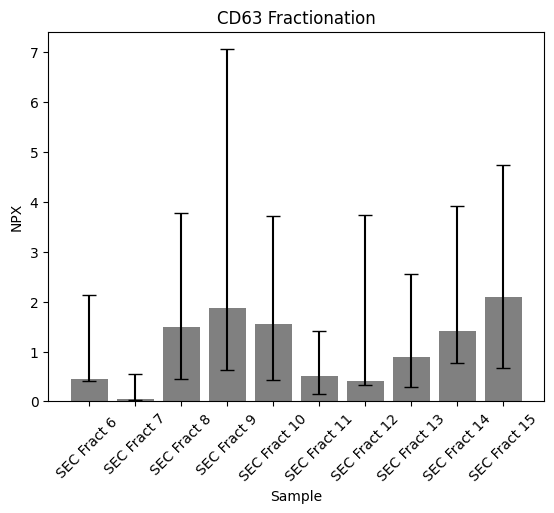

In [19]:
CSF_SAMPLES = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
]

healthy_cd63 = tidy_data[(tidy_data.index.get_level_values("Health") == "Healthy")][["P08962"]]
healthy_sec_cd63 = healthy_cd63[healthy_cd63.index.get_level_values("Sample").str.contains("SEC")]

healthy_sec_cd63.reset_index(level = ["SampleID", "Health", "Sample"], inplace = True)
healthy_sec_cd63["Sample"] = pd.Categorical(healthy_sec_cd63["Sample"], categories = CSF_SAMPLES, ordered = True)
cd63_sorted = healthy_sec_cd63.sort_values("Sample")

median_values = cd63_sorted.groupby("Sample")["P08962"].median()

range_values = cd63_sorted.groupby('Sample')['P08962'].agg(['min', 'max']).reset_index()
yerr_min = range_values['min'].values
yerr_max = range_values['max'].values

plt.bar(median_values.index, median_values, yerr=[yerr_min, yerr_max], capsize=5, color = "gray")
plt.xlabel("Sample")
plt.ylabel("NPX")
plt.title("CD63 Fractionation")
plt.xticks(rotation=45)
plt.show()


In [20]:
cd81 = pd.read_excel("C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\cd81 simoa.xlsx")

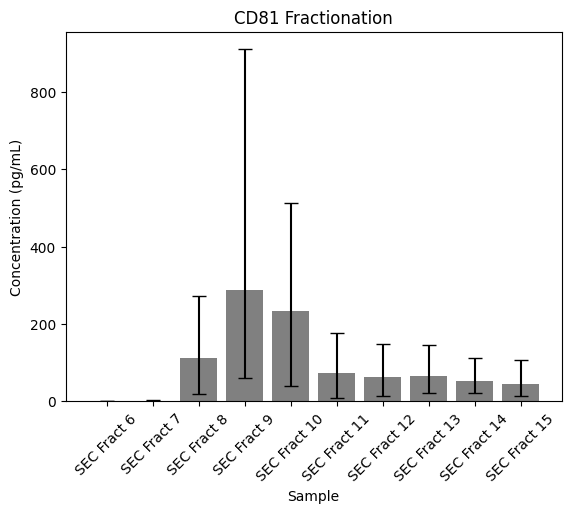

In [83]:
plt.bar(cd81['Sample'], cd81['Median'], yerr=[cd81['Min'], cd81['Max']], capsize=5, color='gray')
plt.xlabel('Sample')
plt.ylabel('Concentration (pg/mL)')
plt.title('CD81 Fractionation')
plt.xticks(rotation=45)
plt.show()

In [22]:
sample_list = ["CSF1", "CSF2", "CSF3", "CSF4", "CSF5", "CSF6", "CSF7", "CSF8"]
def graph_samples(uniprot_id):
    df = tidy_data[uniprot_id]
    df = df.reset_index()
    for sample in sample_list:
        sample_df = df[df["CSF_sample"] == sample]
        plt.bar(sample_df["Sample"], sample_df[uniprot_id], color = "black")
        plt.xlabel("Sample")
        plt.ylabel("Delta")
        plt.xticks(rotation=90)
        plt.title(f"{uniprot_id} {sample}")

        plt.show()
        

In [23]:
assays = pd.read_excel(assay_list_path)

In [24]:
values = analyze_fractionation(tidy_data, ['9', '10'], ['7', '11', '12', '13',], sample_health = "healthy", mean_median_individual = "individual_median")

external_assays = identify_localization(assays, "external")
internal_assays = identify_localization(assays, "internal")
tm_assays = identify_localization(assays, "TMhelix")

In [25]:
len(set(tm_assays))

782

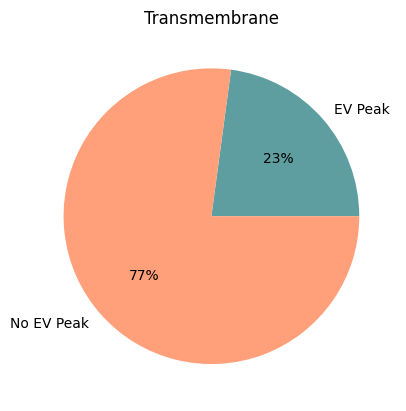

In [26]:
tm_fract = (set(values) & set(tm_assays))
tm_no_fract = set(values) - set(tm_assays)

tm_values = [len(tm_fract), len(tm_no_fract)]
labels = ["EV Peak", "No EV Peak"]
colors = ["cadetblue", "lightsalmon"]

# make a three-panel figure using fix, ax with legend on the side

autopct = lambda x: f"{int(np.round(x))}%"

plt.pie(tm_values, labels = labels, autopct = autopct, colors = colors)
plt.title("Transmembrane")
plt.show()

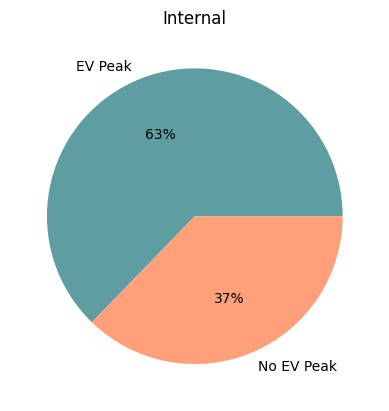

In [27]:
int_fract = (set(values) & set(internal_assays))
int_no_fract = set(values) - set(internal_assays)

int_values = [len(int_fract), len(int_no_fract)]
labels = ["EV Peak", "No EV Peak"]
colors = ["cadetblue", "lightsalmon"]

autopct = lambda x: f"{int(np.round(x))}%"

plt.pie(int_values, labels = labels, autopct = autopct, colors = colors)
plt.title("Internal")
plt.show()

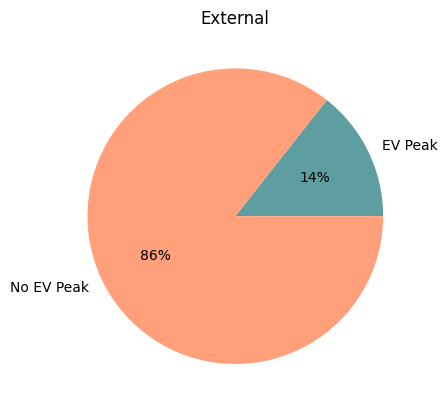

In [28]:
ext_fract = (set(values) & set(external_assays))
ext_no_fract = set(values) - set(external_assays)

ext_values = [len(ext_fract), len(ext_no_fract)]
labels = ["EV Peak", "No EV Peak"]
colors = ["cadetblue", "lightsalmon"]

autopct = lambda x: f"{int(np.round(x))}%"

plt.pie(ext_values, labels = labels, autopct = autopct, colors = colors)
plt.title("External")
plt.show()

In [29]:
tidy_data = clean_up_raw_olink_file(raw_data_path, plate_layout)

brain_rna_seq_data = map_hgnc_ids(brain_rna_seq_path)

astrocytes = mean_cell_type(brain_rna_seq_data, "astrocyte")
endothelial = mean_cell_type(brain_rna_seq_data, "endothelial")
microglia = mean_cell_type(brain_rna_seq_data, "microglia")
oligodendrocytes = mean_cell_type(brain_rna_seq_data, "oligodendrocyte")
neurons = mean_cell_type(brain_rna_seq_data, "neuron")

all_cell_types = pd.merge(
    pd.merge(
        pd.merge(
            pd.merge(astrocytes, endothelial, on="uniprot_ids"),
            microglia,
            on="uniprot_ids",
        ),
        oligodendrocytes,
        on="uniprot_ids",
    ),
    neurons,
    on="uniprot_ids",
)
all_cell_types.set_index("uniprot_ids", inplace=True)

expression_data = all_cell_types.loc[
    :, ["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"]
]

In [30]:
tau = expression_data.apply(lambda row: calculate_enrichment(row, "tau"), axis = 1)

low_tau = tau[tau < 0.25]
tm_low_tau = low_tau[low_tau.index.isin(tm_assays)]
int_low_tau = low_tau[low_tau.index.isin(internal_assays)]

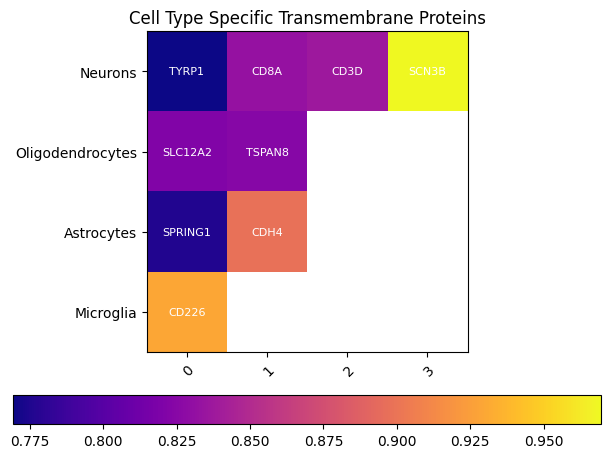

In [31]:
tm_neuron_df = expression_data[expression_data.index.isin(tm_neuron)]
tm_neuron_tau = tm_neuron_df.apply(lambda row: calculate_enrichment(row, "tau"), axis = 1).reset_index()
tm_neuron_tau.columns = ["uniprot_ids", "tau"]
tm_neuron_tau.at[0, "uniprot_ids"] = "CD3D"
tm_neuron_tau.at[1, "uniprot_ids"] = "CD8A"
tm_neuron_tau.at[2, "uniprot_ids"] = "SCN3B"
tm_neuron_tau.at[3, "uniprot_ids"] = "TYRP1"
tm_neuron_tau = tm_neuron_tau.sort_values(by = "tau")

tm_oligodendrocyte_df = expression_data[expression_data.index.isin(tm_oligodendrocyte)]
tm_oligodendrocyte_tau = tm_oligodendrocyte_df.apply(lambda row: calculate_enrichment(row, "tau"), axis = 1).reset_index()
tm_oligodendrocyte_tau.columns = ["uniprot_ids", "tau"]
tm_oligodendrocyte_tau.at[0, "uniprot_ids"] = "SLC12A2"
tm_oligodendrocyte_tau.at[1, "uniprot_ids"] = "TSPAN8"
tm_oligodendrocyte_tau = tm_oligodendrocyte_tau.sort_values(by = "tau")

tm_astrocyte_df = expression_data[expression_data.index.isin(tm_astrocyte)]
tm_astrocyte_tau = tm_astrocyte_df.apply(lambda row: calculate_enrichment(row, "tau"), axis = 1).reset_index()
tm_astrocyte_tau.columns = ["uniprot_ids", "tau"]
tm_astrocyte_tau.at[0, "uniprot_ids"] = "SPRING1"
tm_astrocyte_tau.at[1, "uniprot_ids"] = "CDH4"
tm_astrocyte_tau = tm_astrocyte_tau.sort_values(by = "tau")

tm_microglia_df = expression_data[expression_data.index.isin(tm_microglia)]
tm_microglia_tau = tm_microglia_df.apply(lambda row: calculate_enrichment(row, "tau"), axis = 1).reset_index()
tm_microglia_tau.columns = ["uniprot_ids", "tau"]
tm_microglia_tau.at[0, "uniprot_ids"] = "CD226"
tm_microglia_tau = tm_microglia_tau.sort_values(by = "tau")

tm_neuron_array = np.array(tm_neuron_tau["tau"])
tm_oligodendrocyte_array = np.array(tm_oligodendrocyte_tau["tau"])
tm_astrocyte_array = np.array(tm_astrocyte_tau["tau"])
tm_microglia_array = np.array(tm_microglia_tau["tau"])

max_length = max(len(tm_neuron_array), len(tm_oligodendrocyte_array), len(tm_astrocyte_array), len(tm_microglia_array))
all_tm_array = np.full((4, max_length), np.nan)

all_tm_array[0, :len(tm_neuron_array)] = tm_neuron_array
all_tm_array[1, :len(tm_oligodendrocyte_array)] = tm_oligodendrocyte_array
all_tm_array[2, :len(tm_astrocyte_array)] = tm_astrocyte_array
all_tm_array[3, :len(tm_microglia_array)] = tm_microglia_array

cell_types = ["Neurons", "Oligodendrocytes", "Astrocytes", "Microglia"]
cell_type_targets = ["target1", "target2", "target3", "target4"]

text = []
tm_df_list = [tm_neuron_tau, tm_oligodendrocyte_tau, tm_astrocyte_tau, tm_microglia_tau]
column_name = "uniprot_ids"

for df in tm_df_list: 
    if column_name in df.columns:
        text.extend(df[column_name].tolist())

fig, ax = plt.subplots()
im = ax.imshow(all_tm_array, cmap = "plasma")

ax.set_yticks(np.arange(len(cell_types)), labels = cell_types)

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

ax.set_title("Cell Type Specific Transmembrane Proteins")

for i, cell_type in enumerate(cell_types):
    for j, target in enumerate(cell_type_targets):
        value = all_tm_array[i, j]
        if not np.isnan(value):
            text_label = text.pop(0)  # Get the next label from the list
            ax.text(j, i, text_label, ha='center', va='center', color='white', fontsize=8)

cbar = plt.colorbar(im, orientation='horizontal', pad=0.10)
fig.tight_layout()
plt.show()

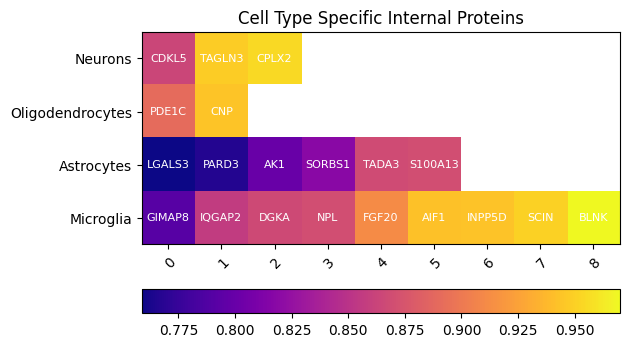

In [32]:
int_neuron_df = expression_data[expression_data.index.isin(int_neuron)]
int_neuron_tau = int_neuron_df.apply(lambda row: calculate_enrichment(row, "tau"), axis = 1).reset_index()
int_neuron_tau.columns = ["uniprot_ids", "tau"]

int_neuron_tau.at[0, "uniprot_ids"] = "CDKL5"
int_neuron_tau.at[1, "uniprot_ids"] = "CPLX2"
int_neuron_tau.at[2, "uniprot_ids"] = "TAGLN3"
int_neuron_tau = int_neuron_tau.sort_values(by = "tau")

int_oligodendrocyte_df = expression_data[expression_data.index.isin(int_oligodendrocyte)]
int_oligodendrocyte_tau = int_oligodendrocyte_df.apply(lambda row: calculate_enrichment(row, "tau"), axis = 1).reset_index()
int_oligodendrocyte_tau.columns = ["uniprot_ids", "tau"]

int_oligodendrocyte_tau.at[0, "uniprot_ids"] = "CNP"
int_oligodendrocyte_tau.at[1, "uniprot_ids"] = "PDE1C"
int_oligodendrocyte_tau = int_oligodendrocyte_tau.sort_values(by = "tau")

int_microglia_df = expression_data[expression_data.index.isin(int_microglia)]
int_microglia_tau = int_microglia_df.apply(lambda row: calculate_enrichment(row, "tau"), axis = 1).reset_index()
int_microglia_tau.columns = ["uniprot_ids", "tau"]

int_microglia_tau.at[0, "uniprot_ids"] = "AIF1"
int_microglia_tau.at[1, "uniprot_ids"] = "BLNK"
int_microglia_tau.at[2, "uniprot_ids"] = "DGKA"
int_microglia_tau.at[3, "uniprot_ids"] = "FGF20"
int_microglia_tau.at[4, "uniprot_ids"] = "GIMAP8"
int_microglia_tau.at[5, "uniprot_ids"] = "INPP5D"
int_microglia_tau.at[6, "uniprot_ids"] = "IQGAP2"
int_microglia_tau.at[7, "uniprot_ids"] = "NPL"
int_microglia_tau.at[8, "uniprot_ids"] = "SCIN"
int_microglia_tau = int_microglia_tau.sort_values(by = "tau")

int_astrocyte_df = expression_data[expression_data.index.isin(int_astrocyte)]
int_astrocyte_tau = int_astrocyte_df.apply(lambda row: calculate_enrichment(row, "tau"), axis = 1).reset_index()
int_astrocyte_tau.columns = ["uniprot_ids", "tau"]

int_astrocyte_tau.at[0, "uniprot_ids"] = "AK1"
int_astrocyte_tau.at[1, "uniprot_ids"] = "LGALS3"
int_astrocyte_tau.at[2, "uniprot_ids"] = "PARD3"
int_astrocyte_tau.at[3, "uniprot_ids"] = "S100A13"
int_astrocyte_tau.at[4, "uniprot_ids"] = "SORBS1"
int_astrocyte_tau.at[5, "uniprot_ids"] = "TADA3"
int_astrocyte_tau = int_astrocyte_tau.sort_values(by = "tau")

int_neuron_array = np.array(int_neuron_tau["tau"])
int_oligodendrocyte_array = np.array(int_oligodendrocyte_tau["tau"])
int_astrocyte_array = np.array(int_astrocyte_tau["tau"])
int_microglia_array = np.array(int_microglia_tau["tau"])

max_length = max(len(int_neuron_array), len(int_oligodendrocyte_array), len(int_astrocyte_array), len(int_microglia_array))
all_int_array = np.full((4, max_length), np.nan)

all_int_array[0, :len(int_neuron_array)] = int_neuron_array
all_int_array[1, :len(int_oligodendrocyte_array)] = int_oligodendrocyte_array
all_int_array[2, :len(int_astrocyte_array)] = int_astrocyte_array
all_int_array[3, :len(int_microglia_array)] = int_microglia_array

# all_int_array = all_int_array[:, np.argsort(all_int_array, axis=1)]
cell_type_targets = ["target1", "target2", "target3", "target4", "target5", "target6", "target7", "target8", "target9"]
cell_types = ["Neurons", "Oligodendrocytes", "Astrocytes", "Microglia"]

text = []
df_list = [int_neuron_tau, int_oligodendrocyte_tau, int_astrocyte_tau, int_microglia_tau]
column_name = "uniprot_ids"

for df in df_list: 
    if column_name in df.columns:
        text.extend(df[column_name].tolist())

fig, ax = plt.subplots()
im = ax.imshow(all_int_array, cmap = "plasma")

ax.set_yticks(np.arange(len(cell_types)), labels = cell_types)

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

ax.set_title("Cell Type Specific Internal Proteins")

for i, cell_type in enumerate(cell_types):
    for j, target in enumerate(cell_type_targets):
        value = all_int_array[i, j]
        if not np.isnan(value):
            text_label = text.pop(0)  # Get the next label from the list
            ax.text(j, i, text_label, ha='center', va='center', color='white', fontsize=8)

cbar = plt.colorbar(im, orientation='horizontal', pad=0.10)
fig.tight_layout()
plt.show()